# <img src="https://uxwing.com/wp-content/themes/uxwing/download/business-professional-services/boy-services-support-icon.png" style="height: 40px"/> MLRun's Call Center Demo

In this demo we will be showcasing how we used GenAI to turn call center conversation audio files of customers and agents into valueable data in a single workflow orchastrated by MLRun.

MLRun will be automating the entire workflow, auto-scale resources as needed and automatically log and parse values between the workflow different steps.

The demo will demonstrate two usages of GenAI:
* **Unstructured Data Generation** - Generating audio data with ground truth metadata to evaluate our analysis.
* **Unstructured Data Analysis** - Turning audio calls to text and into tabular features.

## Table of contents:

1. [Project Creation](#project_creation)
2. [Calls Data Generation](#calls_data_generation)
3. [Calls Analysis](#calls_analysis)
4. [Calls Viewer](#calls_viewer)
5. [Future Work](#future_work)

___
<a id="project_creation"></a>
## 1. Project Creation

### 1.1. Install Requirements

For the demo, we will need:
* [**MLRun**](https://www.mlrun.org/) - Orchestrate the demo's workflows.
* [**SQLAlchemy**](https://www.sqlalchemy.org/) - Manage the MySQL DB.
* [**Gradio**](https://www.gradio.app/) - To view the call center DB.

In [ ]:
!pip install mlrun
!pip install gradio==3.36
!pip install -U SQLAlchemy

### 1.2. Fill Tokens & URL

There are 4 requirred tokens to run the demo end-to-end:
* [OpenAI ChatGPT](https://chat.openai.com/) - In order to generate conversations. 2 tokens are required:
  * `OPENAI_API_KEY`
  * `OPENAI_API_BASE`
  
> Note: The requirement for OpenAI token will be removed soon in favor of an open-source LLM.

* [Huggingface](https://huggingface.co/) - To use PyAnnote models from the hub for Speech Diarization (see section [3. Calls Analysis](#calls_analysis)). 
* [MySQL](https://www.mysql.com/) - A URL with user name and password for collecting the calls into the DB.



In [21]:
import os
import sys
import mlrun

sys.path.insert(0, os.path.abspath("./"))

from src.common import ProjectSecrets

In [22]:
# OpenAI tokens:
OPENAI_API_KEY = ""
OPENAI_API_BASE = ""

# Huggingface token:
HUGGINGFACE_TOKEN = ""

# MySQL URL:
MYSQL_URL = ""

In [23]:
os.environ[ProjectSecrets.OPENAI_API_KEY] = OPENAI_API_KEY
os.environ[ProjectSecrets.OPENAI_API_BASE] = OPENAI_API_BASE
os.environ[ProjectSecrets.HUGGING_FACE_HUB_TOKEN] = HUGGINGFACE_TOKEN
os.environ[ProjectSecrets.MYSQL_URL] = MYSQL_URL

### 1.3. Setup Project

We'll create the MLRun project with the function [`mlrun.get_or_create_project`](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.get_or_create_project). The project is being created (or loaded if previously created) and being setup automatically according to the [project_setup.py](./project_setup.py) file located in this repo. 

This file is setting the functions accoridng to the given `parameters` down below. Feel free to set them as you wish:

* `source : str` - The git repo source of the project to clone when each function is running.
* `default_image : str` - The image to use for running the workflow's functions.
* `gpus: int` - The amount of GPUs to use when running the demo. 0 means CPU.

> Note: Multiple GPUs (`gpus` > 1) will automatically deploy [OpenMPI](https://www.open-mpi.org/) jobs for better performance and GPU utilization.

You may notice there are not many functions under the source directory, that's because most of the code in this project is being imported from [**MLRun's Functions Hub**](https://www.mlrun.org/hub/) - A collection of reusable functions and assets that make the move to production easier and faster!

In [4]:
project = mlrun.get_or_create_project(
    name="call-center-demo",
    context="./",
    user_project=True,
    parameters={
        "source": "git://github.com/guy1992l/mlrun-call-center-demo.git#v2",
        "default_image": "guyliguazio/call-center-11.8:1.4.1.6",
        "gpus": 4,
    },
)

Project Source: git://github.com/guy1992l/mlrun-call-center-demo.git#v2
> 2023-11-01 13:25:10,665 [info] Project loaded successfully: {'project_name': 'call-center-demo-new-v2222'}


___
<a id="calls_data_generation"></a>
## 2. Calls Data Generation

The data generation workflow includes 3 steps. You can see each function's docstring and code by clicking the function name in the following list:

1. [**Generate Conversations**](./src/calls_generation/conversations_generator.py): Using OpenAI's ChatGPT we generate converrsations and metadata for the demo. We randomize prompts and keep their values for ground truths to evaluate the analysis later on.
2. [**Text To Speech**]() - ***Hub Function***: Using SunoAI's Bark, we generrate audio files frrom the conversations text files produced.
3. [**Prepare Batch**](./src/calls_generation/conversations_generator.py): The last step is to wrap all of our generated data to an input batch that is ready forr the analysis workflow!

### 2.1. Workflow Run

Let us run the [described workflow](./src/workflows/calls_generation.py) by calling the project's method [`project.run`](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.MlrunProject.run).

Parameters passed to the function can be adjusted according to the workflow `arguments`. Feel free to set them as you wish. You may choose the `amount` of calls you wish to generate, the models to use and configurre the metadata as you wish.

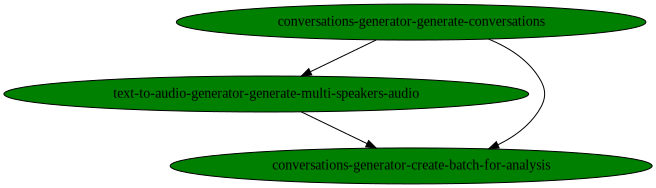

In [4]:
calls_generation_workflow = project.run(
    name="calls-generation",
    arguments={
        # "output_directory": os.path.abspath("./outputs"),
        "amount": 4,
        "generation_model": "gpt-4",
        "text_to_speech_model": "small",
        "language": "en",
        "available_voices": [
            "v2/en_speaker_0", 
            "v2/en_speaker_1", 
            "v2/en_speaker_2", 
            "v2/en_speaker_3", 
            "v2/en_speaker_4", 
            "v2/en_speaker_5", 
            "v2/en_speaker_6", 
            "v2/en_speaker_7", 
            "v2/en_speaker_8", 
            "v2/en_speaker_9"
        ],
        "min_time": 2,
        "max_time": 6,
        "from_date": "10.30.2023",
        "to_date": "10.31.2023",
        "from_time": "09:00",
        "to_time": "17:00",
    },
    watch=True,
    dirty=True,
    timeout=60 * 120,
)

### 2.2. Workflow Results

Let's hearr one of the conversations we generated:

In [28]:
import IPython
import glob

IPython.display.Audio(list(glob.glob("./outputs/audio_files/*.wav"))[0])

___
<a id="calls_analysis"></a>
## 3. Calls Analysis

The workflow include multiple steps where all the main functions are imporrted from **MLRun's Functions Hub**. You can see each hub function's docstring, code and example by clicking the function name in the following list:

1. [**Insert Calls Data to DB**](./src/calls_analysis/db_management.py): Insert the calls metadata to the MySQL DB.
2. [**Perform Speech Diarization**]() - ***Hub Function***: Analyze which person is talking when during the call for better transcription and analysis later on. Diarization gives context to the LLM and yields better results. The function uses [PyAnnote-Audio](https://github.com/pyannote/pyannote-audio) diarization model pipeline. It requires to accept [pyannote/segmentation-3.0](https://huggingface.co/pyannote/segmentation-3.0) and [pyannote/speaker-diarization-3.0](https://huggingface.co/pyannote/speaker-diarization-3.0) user conditions.
3. [**Transcribe**](https://github.com/mlrun/functions/tree/master/transcribe) - A **hub function** that uses [Faster Whisper](https://github.com/guillaumekln/faster-whisper) model to transcribe the calls into text and save them as text files. It is an optimized version of [OpenAI's Whisper](https://openai.com/research/whisper) model. In addition, the following features are extracted and stored in a dataset:
   
   * `language` - The detected language in the conversation.
   * `language_probabilityt` - The confidence of the language classification.
   * `duration` - The duration of the audio file in seconds.
  
4. [**Recognize PII**](https://github.com/mlrun/functions/tree/master/pii_recognizer) - ***Hub Function***: A **hub function** that uses 3 techniques to recognize private identfiable information: RegEx, [Flair](https://flairnlp.github.io/) and [Microsoft's Presidio Analyzer](https://microsoft.github.io/presidio/analyzer/) and [Anonymizer](https://microsoft.github.io/presidio/anonymizer/). The function clear the recognized private data and produces multiple artifacts to review and understand the recogniztion process.

5. [**Analyze**](https://github.com/mlrun/functions/tree/master/question_answering) - ***Hub Function***: Use a LLM to analyze a given text. It expects a prompt template and questions to send to the LLM and construct a dataset out of its answers. In this demo we will use a GPTQ quantized version of [Mistral-7B](https://huggingface.co/TheBloke/Mistral-7B-OpenOrca-GPTQ) to analyze our conversation calls. It will help us extract the following features:
   
   * `topic` - The general subject of the call.
   * `summary` - The summary of the entire call in few sentences.
   * `concern_addressed` - Whether the client's concern was addressed by the end of the call. Can be one of {yes, no}.
   * `customer_tone` - The general customer tone durring the call. Can be one of {posetive, netural, negative}.
   * `agent_tone` - The general agent tone durring the call. Can be one of {posetive, netural, negative}.

6. [**Postprocess Analysis Answers**](./src/postprocess.py) - A project function used to postprocess the LLM's answers before updating them into the DB.

Between each step, there is a call for the function [**Update Calls**](./src/calls_analysis/db_management.py) that is updating the calls DB with their newly collected data and status.

### 3.2. Run The Workflow

We will now run the workflow using the following parameters:

* `data_path : str` - Path to the conversation audio files directory or a given input batch.

> Notice: We pass the input batch frorm the workflow to the `data_path` using the artifact's store path. 

* `speaker_per_channel: bool` - Whether do perforrm diarization per channel.
* `transcribe_model : str` - The model to use for the transcribe function. Must be one of the official model names listed [here](https://github.com/guillaumekln/faster-whisper).
* `pii_recognition_model : str` - The model to use. Can be "spacy", "flair", "pattern" or "whole".
* `pii_recognition_entities : Listr[str]` - The list of entities to recognize.
* `pii_recognition_entity_operator_map: Dict[str, tuple]` - 
* `question_answering_model : str` - The model to use for asnwering the given questions.

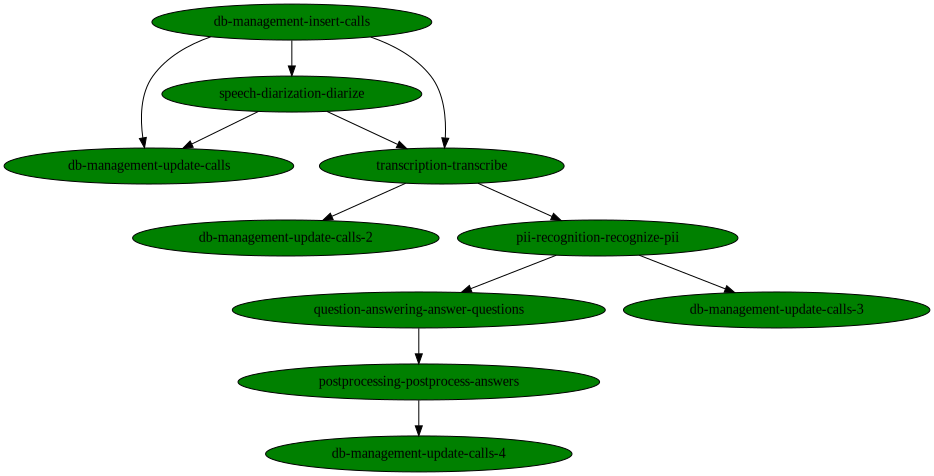

In [4]:
workflow2_run = project.run(
    name="calls-analysis",
    arguments={
        "data_path": "store://artifacts/call-center-demo-new-v2222-guyl/conversations-generator-create-batch-for-analysis_calls_batch#0:latest",
        "speaker_per_channel": True,
        "transcribe_model": "tiny",
        "pii_recognition_model": "whole",
        "pii_recognition_entities": ['PERSON', "EMAIL", "PHONE"],
        "pii_recognition_entity_operator_map": {
            "PERSON": ("replace", {"new_value": "John Doe"}),
            "EMAIL": ("replace", {"new_value": "john_doe@email.com"}),
            "PHONE": ("replace", {"new_value": "123456789"}),
        },
        "question_answering_model": "TheBloke/Mistral-7B-OpenOrca-GPTQ",
    },
    watch=False,
    dirty=True,
    timeout=60 * 120,
)

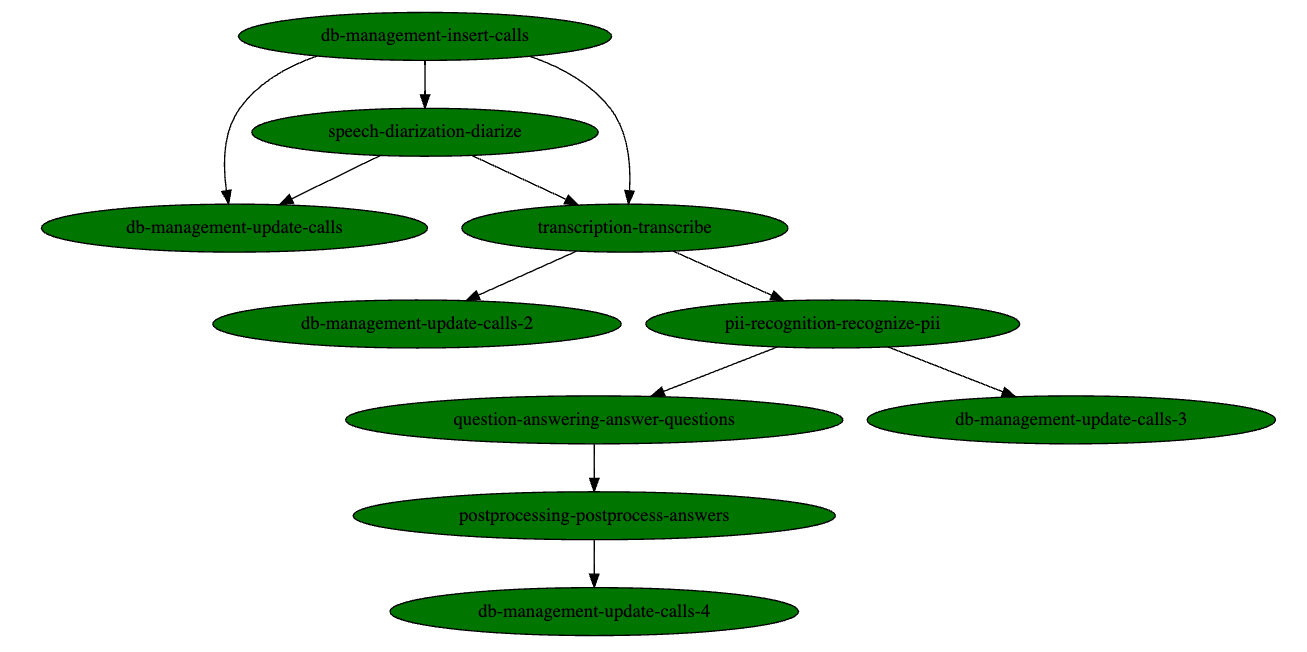

___
<a id="calls_viewer"></a>
## 4. Calls Viewer

While the workflow is running, we can view the data and features as they are being collected.

> Note: As each step in the workflow is automatically logged, it can be viewed as well separatly in the MLRun UI under the project's artifacts. MLRun's experiment tracking enables full exploration and reproducibility between steps in a workflow due to its automatic logging features. Here we only see the MySQL DB.

In [29]:
import gradio as gr
import pandas as pd
import numpy as np
import os
from src.calls_analysis.db_management import get_calls


CALLS_DF = get_calls()

# Load files when pressing on cell (will work only on id cell)
def load_files(evt: gr.SelectData):
    global CALLS_DF
    call_id = CALLS_DF["call_id"][evt.index[0]]
    print(call_id)
    audio_path = f"./outputs/audio_files/{call_id}.wav"
    txt_path = f"./outputs/anonymized_files/{call_id}.txt"
    with open(txt_path) as f:
        lines = f.read()
    audio = gr.Audio.update(audio_path, interactive=False)
    return audio, lines

# relod table according to new df 
def refresh_table():
    global CALLS_DF
    CALLS_DF = get_calls()
    return gr.Dataframe.update(CALLS_DF)

# frontend 
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=2):
            pass
        with gr.Column(scale=1):
            refresh_button = gr.Button(value="Refresh")
    with gr.Row():
        with gr.Column(scale=1):
            table = gr.Dataframe(CALLS_DF)
    with gr.Row():
        with gr.Column(scale=1):
            call = gr.Audio()
        with gr.Column(scale=1):
            text_file = gr.TextArea()
    
    #connect widgets to functions
    table.select(fn=load_files, inputs=None , outputs=[call, text_file])
    refresh_button.click(refresh_table, None, table)

In [30]:
demo.launch(share=True, height=685)

Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://9049ca01a515a5f9a3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


___
<a id="future_work"></a>
## 5. Future Work

This demo was a proof of concept for LLMs feature extraction capabilities, while using MLRun for the orchestration from developemny to production. The demo is being further developed and you are welcome to track and develop it with us:

### v0.3
#### New Features
* [ ] **Open Source Data Generation Workflow** - Replace OpenAI ChatGPT with an open-source LLM.
* [ ] **Data Storage** - Generated data files will be uploaded into a data storage like S3.
* [ ] **Milvus as Vecftor DB** - PII free transcription will be saved in a Milvus DB for further data analysis and application features.
* [ ] **Data Analysis Workflow** - Workflow to analyze the collected data from the RDB (MySQL) and VDB (Milvus).

### v0.2
#### New Features
* [x] **MySQL as Relational DB** - Store all the collected analysis and data in a MySQL database.
* [x] **Speech Diarization** - Know who talks when by performing speech diarization per channel.
* [x] **Translation** - Enable translating into English the transcriptions for inferring thorugh the open source LLM.

#### Improvements
* [x] **Distributed Transcription and Diarization** - Add OpenMPI support to distribute the pipeline functions across multiple workers.
* [x] **Batched Inference** - 
* [x] **Mistral-7B Instead of Falcon-40B** - Use a newer and smaller model for better resutls and faster inference.
* [x] **GPTQ Quantization** - Use a GPTQ quantized model for analysis for faster inference time.

### v0.1
* [x] **Trasncription** - Use Open AI's Whisper for transcribing audio calls.
* [x] **Anonimization** - Anonimize the text before inferring.
* [x] **Analysis** - Perform question asnwering for feature extraction using Falcon-40B.